## Feature Engineering
Neste notebook vamos pre-processar os dados e realizar feature engineering

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestRegressor
import os
import pickle

def performance_metrics(y_pred,y_test):
    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_test, y_pred)

    # MAPE (Mean Absolute Percentage Error)
    n = len(y_pred)
    mape = 0
    error = 0 # quando o stock nao teve alteracao e o crescimento foi de 0% descartamos
    for i in range(n):
        if y_test.iloc[i] == 0: # evitar dividir por 0
            error += 1
            continue
        mape += (abs(y_test.iloc[i]-y_pred[i]) / (y_test.iloc[i]))
    mape *= 100/n 

    print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")
    print(f"Mean Absolute Error (MAE): {mae:.5f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.5}% - (casos onde y_test=0: {error})")
    return[rmse,mae,mape]


def save_pkl(data, path):
    try:
        with open(path, "wb") as saved_data:
            pickle.dump(data, saved_data)
    except:
        print('Fail to save data')

def load_pkl(path):
    try:
        with open(path, "rb") as loaded_data:
            to_return = pickle.load(loaded_data)
        return to_return
    except:
        print('Fail to load data')
        return None

Dados para treinar e prever se o stock vai subir ou descer do inicio para o final do dia
- ["day_of_week", "daily_return_1", "daily_return_2", "daily_return_3", "weekly_return", "volatility_prev_day"]

In [14]:
# exemplo de como vai ficar para cada empresa
def feature_eng(df):    
    df.index = pd.to_datetime(df.index)

    # o dia da semana
    df['day_of_week'] = df.index.dayofweek  # 0=segunda, 1=terca, ... , 4=sexta
    # para calculos intermedios, no final vamos descartar
    df['close_prev_day'] = df['close'].shift(1)
    df['close_last_week'] = df['close'].shift(5)

    # crescimento do ultimos 3 dias
    df['daily_return_1'] = round((df["close"]-df["open"])/ df["open"],6).shift(1)
    df['daily_return_2'] = round((df["close"]-df["open"])/ df["open"],6).shift(2)
    df['daily_return_3'] = round((df["close"]-df["open"])/ df["open"],6).shift(3)
    # crescimento da ultima semana
    df['weekly_return'] = round((df["close_prev_day"]-df["close_last_week"])/ df["close_last_week"],6)
    # volatilidade do dia anterior
    df['volatility_prev_day'] = round((df['high'] - df['low']) / df['open'],6).shift(1)

    df['return'] = df['close'].pct_change()

    df['deviation'] = df['return'].rolling(window=31, min_periods=1).std()

    df['target'] = round((df["close"]-df["open"])/ df["open"],6)

    df = df.dropna()
    df = df.drop(['close_prev_day', 'close_last_week','return'], axis=1)
    return df

''' 
        # # Calculate 10-day SMA
        # sub_set['SMA_10'] = sub_set['close'].rolling(window=10).mean()

        # # Calculate 10-day EMA
        # sub_set['EMA_10'] = sub_set['close'].ewm(span=10, adjust=False).mean()

        # # RSI Calculation
        # window_length = 14
        # # Calculate daily price changes
        # delta = sub_set['close'].diff()
        # # Separate gains and losses
        # gain = delta.where(delta > 0, 0)
        # loss = -delta.where(delta < 0, 0)
        # # Calculate rolling average gains and losses
        # avg_gain = gain.rolling(window=window_length, min_periods=1).mean()
        # avg_loss = loss.rolling(window=window_length, min_periods=1).mean()
        # # Calculate RS and RSI
        # rs = avg_gain / avg_loss
        # sub_set['RSI'] = 100 - (100 / (1 + rs))


        # fast_ema = sub_set['close'].ewm(span=12, adjust=False).mean()
        # slow_ema = sub_set['close'].ewm(span=26, adjust=False).mean()

        # sub_set['MACD'] = fast_ema - slow_ema
        # sub_set['Signal_Line'] = sub_set['MACD'].ewm(span=9, adjust=False).mean()

        # # Bollinger Bands Calculation
        # window = 20
        # sub_set['SMA_20'] = sub_set['close'].rolling(window=window).mean()
        # sub_set['STD_20'] = sub_set['close'].rolling(window=window).std()

        # sub_set['Upper_Band'] = sub_set['SMA_20'] + (2 * sub_set['STD_20'])
        # sub_set['Lower_Band'] = sub_set['SMA_20'] - (2 * sub_set['STD_20'])
        '''

" \n        # # Calculate 10-day SMA\n        # sub_set['SMA_10'] = sub_set['close'].rolling(window=10).mean()\n\n        # # Calculate 10-day EMA\n        # sub_set['EMA_10'] = sub_set['close'].ewm(span=10, adjust=False).mean()\n\n        # # RSI Calculation\n        # window_length = 14\n        # # Calculate daily price changes\n        # delta = sub_set['close'].diff()\n        # # Separate gains and losses\n        # gain = delta.where(delta > 0, 0)\n        # loss = -delta.where(delta < 0, 0)\n        # # Calculate rolling average gains and losses\n        # avg_gain = gain.rolling(window=window_length, min_periods=1).mean()\n        # avg_loss = loss.rolling(window=window_length, min_periods=1).mean()\n        # # Calculate RS and RSI\n        # rs = avg_gain / avg_loss\n        # sub_set['RSI'] = 100 - (100 / (1 + rs))\n\n\n        # fast_ema = sub_set['close'].ewm(span=12, adjust=False).mean()\n        # slow_ema = sub_set['close'].ewm(span=26, adjust=False).mean()\n\n        

In [15]:
df_train = pd.read_csv("dataset_by_sector/train/Industrials.csv", index_col=0)
df_test = pd.read_csv("dataset_by_sector/test/Industrials.csv", index_col=0)
df_train = df_train[df_train["ticker"]=="AXON"]
df_test = df_test[df_test["ticker"]=="AXON"]
df_train = feature_eng(df_train.copy())
df_test = feature_eng(df_test.copy())

In [16]:
df_test.head()

,open,high,low,close,adjclose,volume,ticker,day_of_week,daily_return_1,daily_return_2,daily_return_3,weekly_return,volatility_prev_day,deviation,target
2023-10-11,216.639999,220.710007,216.000000,220.000000,220.000000,728500,AXON,2,0.025190,0.032690,0.034072,0.106264,0.031905,0.014275,0.015510
2023-10-12,220.679993,220.679993,214.190002,215.410004,215.410004,424900,AXON,3,0.015510,0.025190,0.032690,0.121819,0.021741,0.022632,-0.023881
2023-10-13,216.630005,217.880005,214.279999,215.429993,215.429993,410200,AXON,4,-0.023881,0.015510,0.025190,0.078668,0.029409,0.021657,-0.005539
2023-10-16,217.199997,220.460007,216.679993,220.050003,220.050003,307000,AXON,0,-0.005539,-0.023881,0.015510,0.031703,0.016618,0.020187,0.013122
2023-10-17,218.529999,223.300003,218.050003,222.539993,222.539993,568900,AXON,1,0.013122,-0.005539,-0.023881,0.022110,0.017403,0.018938,0.018350


## Data Engineering Test

In [17]:
# dividir os dados em treino e teste
X_train = df_train[['day_of_week', 'daily_return_1', 'daily_return_2', 'daily_return_3','weekly_return', 'volatility_prev_day', 'deviation']]
y_train = df_train['target']  # target
X_test = df_test[['day_of_week', 'daily_return_1', 'daily_return_2', 'daily_return_3','weekly_return', 'volatility_prev_day', 'deviation']]
y_test = df_test['target']  # target

# treinar a random forest regressor
rf = RandomForestRegressor(n_estimators= 500, min_samples_split = 50, random_state=42)
rf.fit(X_train, y_train)

# prever
y_pred = rf.predict(X_test)


In [18]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your test set's index is the 'date'
# The index of X_test should contain datetime values for each test prediction.

# Initialize SHAP explainer
explainer = shap.TreeExplainer(rf)

# Compute SHAP values for the test set (excluding the 'date' index)
shap_values = explainer.shap_values(X_test)

# Determine the most important feature for each prediction
results = []
for i, row in enumerate(shap_values):  # Iterate over SHAP values
    feature_importances = dict(zip(X_test.columns, row))
    most_important_feature = max(feature_importances, key=feature_importances.get)  # Find feature with highest SHAP value
    results.append({'date': X_test.index[i], 'most_important_feature': most_important_feature})

# Convert to DataFrame for better readability
results_df = pd.DataFrame(results)

# Plot the results: most important feature for each prediction

# Plot feature counts (Bar Plot)
plt.figure(figsize=(12, 6))
feature_counts = results_df['most_important_feature'].value_counts()
sns.barplot(x=feature_counts.index, y=feature_counts.values)
plt.title('Feature Importance Frequency Across Predictions')
plt.xlabel('Features')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot feature importance per day (Time Series Plot)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=results_df, x='date', y='most_important_feature', hue='most_important_feature', palette='Set2')
plt.title('Most Important Feature Per Prediction Over Time')
plt.xlabel('Date')
plt.ylabel('Most Important Feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save the results to a CSV file (optional)
results_df.to_csv("most_important_features.csv", index=False)


ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.2.

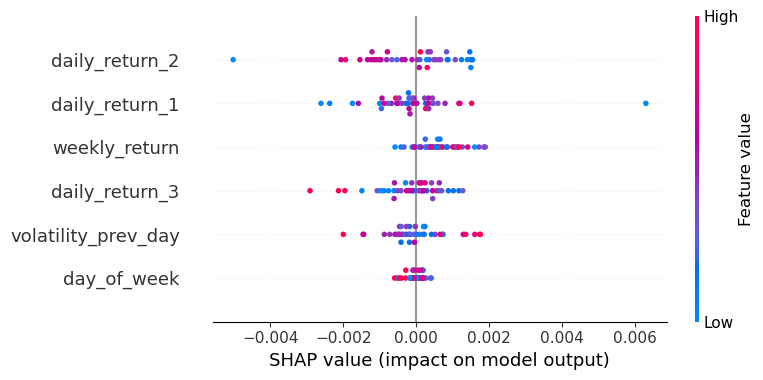

In [38]:
import shap

# Explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Visualize a single prediction
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])

# Summary plot for all predictions
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


c:\Users\guica\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\guica\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\guica\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\guica\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\guica\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\guica\anaconda3\Lib\site-packages\sklearn\base.py:439: U

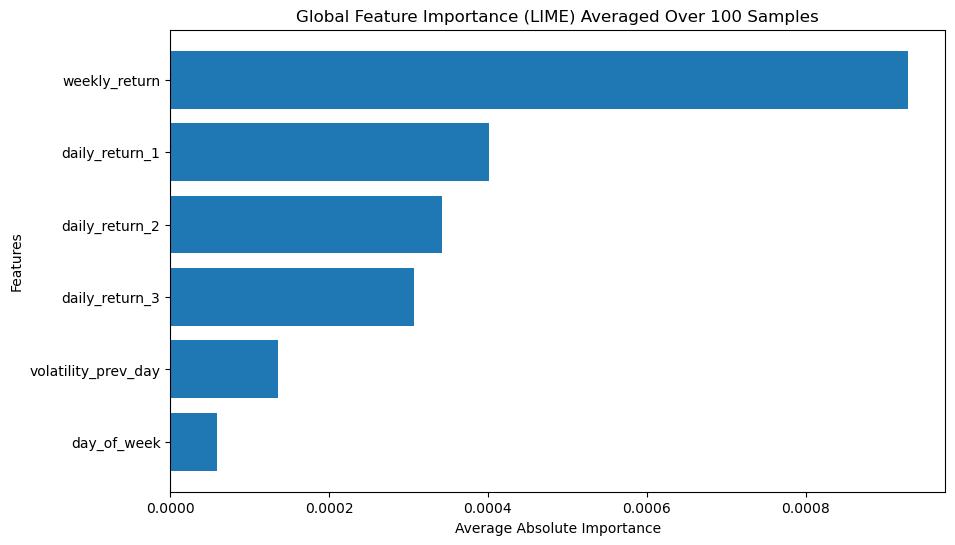

In [46]:
import numpy as np
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor  # Example regressor

# Instantiate the LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    mode='regression',
    discretize_continuous=False
)

# Function to collect feature importances across multiple samples
import re

def get_lime_global_importance(model, explainer, X_test, num_samples=100):
    """
    Compute global feature importance using LIME for multiple samples.
    """
    num_samples = min(num_samples, len(X_test))  # Validate sample size
    global_importance = np.zeros(X_train.shape[1])  # Placeholder for aggregated importance

    selected_indices = np.random.choice(range(len(X_test)), size=num_samples, replace=False)

    for idx in selected_indices:
        sample = X_test.iloc[idx]
        explanation = explainer.explain_instance(
            data_row=sample.values,
            predict_fn=lambda x: model.predict(x).flatten()
        )
        # Add feature weights for the current instance
        for feature, weight in explanation.as_list():
            # Extract base feature name before any transformation
            base_feature = re.split(r' <= | > ', feature)[0]
            if base_feature in X_train.columns:  # Match the base name
                feature_idx = X_train.columns.get_loc(base_feature)
                global_importance[feature_idx] += abs(weight)  # Accumulate absolute importance

    return global_importance / num_samples  # Average importance


# Get global feature importance
num_samples = 100  # Adjust number of samples for averaging
global_importance = get_lime_global_importance(rf, explainer, X_test, num_samples=num_samples)

# Plot the global feature importance
sorted_idx = np.argsort(global_importance)
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns[sorted_idx], global_importance[sorted_idx])
plt.title(f"Global Feature Importance (LIME) Averaged Over {num_samples} Samples")
plt.xlabel("Average Absolute Importance")
plt.ylabel("Features")
plt.show()

# Save feature importance to CSV
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": global_importance
}).sort_values(by="Importance", ascending=False)
importance_df.to_csv("lime_global_importance.csv", index=False)


In [39]:
shap_values.shape

(41, 6)

In [34]:
performance_metrics(y_pred,y_test)
rf.feature_importances_

Root Mean Squared Error (RMSE): 0.01492
Mean Absolute Error (MAE): 0.01007
Mean Absolute Percentage Error (MAPE): 21.532% - (casos onde y_test=0: 0)


array([0.01986132, 0.22177842, 0.200862  , 0.17047078, 0.16910234,
       0.21792515])

In [51]:
print("Valor de crescimento diário ao longo do mes de novembro e dezembro de 2023\nNo setor 'Consumer_Discretionary' com 30 empresas")
for i in range(len(y_test)):
    print(f"Valor real: {y_test.iloc[i]} | {y_pred[i]:.6f} :Valor previsto ")

Valor de crescimento diário ao longo do mes de novembro e dezembro de 2023
No setor 'Consumer_Discretionary' com 30 empresas
Valor real: 0.010734 | 0.000725 :Valor previsto 
Valor real: 0.002384 | -0.002337 :Valor previsto 
Valor real: 0.024909 | -0.002236 :Valor previsto 
Valor real: -0.011532 | 0.004946 :Valor previsto 
Valor real: -0.002536 | -0.002735 :Valor previsto 
Valor real: 0.022628 | -0.001903 :Valor previsto 
Valor real: -0.063111 | -0.000423 :Valor previsto 
Valor real: 0.008235 | 0.004976 :Valor previsto 
Valor real: 0.001787 | -0.004769 :Valor previsto 
Valor real: 0.000994 | -0.000605 :Valor previsto 
Valor real: -0.004144 | 0.002895 :Valor previsto 
Valor real: 0.003197 | -0.000471 :Valor previsto 
Valor real: -0.006535 | -0.000752 :Valor previsto 
Valor real: 0.008245 | 0.002708 :Valor previsto 
Valor real: 0.010708 | 0.004820 :Valor previsto 
Valor real: -0.006829 | 0.002703 :Valor previsto 
Valor real: 0.005635 | -0.002008 :Valor previsto 
Valor real: 0.003519 | 0.0

In [98]:
performance_metrics(y_pred,y_test)
rf.feature_importances_

Root Mean Squared Error (RMSE): 0.01408
Mean Absolute Error (MAE): 0.01040
Mean Absolute Percentage Error (MAPE): 0.24987% - (casos onde y_test=0: 0)


array([0.01639587, 0.17452946, 0.19590679, 0.18092324, 0.2281051 ,
       0.20413954])

In [ ]:
# day_of_week	daily_return_1	daily_return_2	daily_return_3	weekly_return	volatility_prev_day
performance_metrics(y_pred,y_test)
rf.feature_importances_

Root Mean Squared Error (RMSE): 0.01398
Mean Absolute Error (MAE): 0.01036
Mean Absolute Percentage Error (MAPE): 0.53716% - (casos onde y_test=0: 0)


array([0.01561944, 0.1766727 , 0.19759446, 0.17964037, 0.22931966,
       0.20115337])

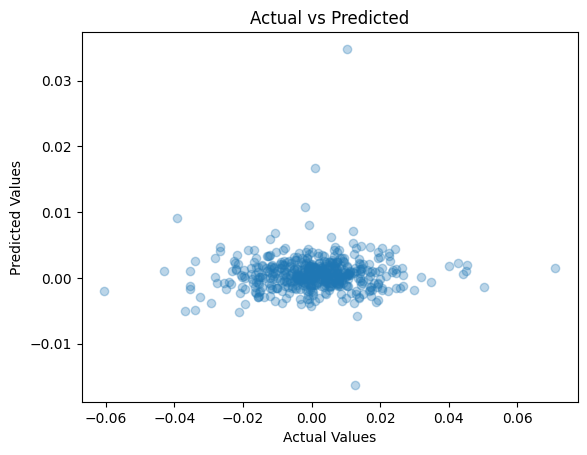

In [99]:
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.show()


### Função principal para processar por setor

### Testing performance

Vamos testar a performance em 1 setor para analisar o comportamento das features escolhidas

In [7]:
# dataset- Industrials
df = pd.read_csv("dataset_by_sector/train/Industrials.csv", index_col=0)
df.index = pd.to_datetime(df.index)

In [8]:
final = data_engineering(df)
final.head()

,open,high,low,close,adjclose,volume,ticker,day_of_week,daily_return_1,daily_return_2,daily_return_3,weekly_return,volatility_prev_day,target
2020-03-26,14.000000,15.45,14.00,15.45,14.542329,76400,CARR,3,0.139830,-0.093023,-0.094902,0.120833,0.139830,0.103571
2020-03-27,15.000000,16.00,14.55,14.55,13.695203,486500,CARR,4,0.103571,0.139830,-0.093023,0.211765,0.103571,-0.030000
2020-03-30,15.250000,16.50,15.25,15.90,14.965888,210000,CARR,0,-0.030000,0.103571,0.139830,0.260832,0.096667,0.042623
2020-03-31,16.389999,17.25,14.56,17.25,16.236584,461500,CARR,1,0.042623,-0.030000,0.103571,0.358974,0.081967,0.052471
2020-04-01,16.000000,16.00,14.56,15.05,14.165826,2998900,CARR,2,0.052471,0.042623,-0.030000,0.282528,0.164124,-0.059375


In [9]:
df_sorted = final.sort_index()
df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 89837 entries, 2010-01-11 to 2023-12-29
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   open                 89837 non-null  float64
 1   high                 89837 non-null  float64
 2   low                  89837 non-null  float64
 3   close                89837 non-null  float64
 4   adjclose             89837 non-null  float64
 5   volume               89837 non-null  int64  
 6   ticker               89837 non-null  object 
 7   day_of_week          89837 non-null  int32  
 8   daily_return_1       89837 non-null  float64
 9   daily_return_2       89837 non-null  float64
 10  daily_return_3       89837 non-null  float64
 11  weekly_return        89837 non-null  float64
 12  volatility_prev_day  89837 non-null  float64
 13  target               89837 non-null  float64
dtypes: float64(11), int32(1), int64(1), object(1)
memory usage: 9.9+ MB


In [170]:

# features escolhidas
X = final[["day_of_week", "daily_return_1", "daily_return_2", "daily_return_3", "weekly_return", "volatility_prev_day"]]
# X = final[['day_of_week', 'daily_return_1', 'daily_return_2', 'daily_return_3',
#        'weekly_return', 'volatility_prev_day', 'SMA_10', 'EMA_10', 'RSI',
#        'MACD', 'Signal_Line', 'SMA_20', 'STD_20', 'Upper_Band', 'Lower_Band']]
y = final['target']  # target

# 2/3 treino | 1/3 teste, e mantendo os dados em ordem cronologica
div = 2 * len(final)//3

X_train = X[:div]
X_test = X[div:]
y_train = y[:div]
y_test = y[div:]


# treinar a random forest regressor
rf = RandomForestRegressor(n_estimators=500, min_samples_split=50, random_state=42)
rf.fit(X_train, y_train)

# prever
y_pred = rf.predict(X_test)


In [169]:
# X = final[['day_of_week', 'daily_return_1', 'daily_return_2', 'daily_return_3',
#       'weekly_return', 'volatility_prev_day', 'SMA_10', 'EMA_10', 'RSI',
#       'MACD', 'Signal_Line', 'SMA_20', 'STD_20', 'Upper_Band', 'Lower_Band']]
performance_metrics(y_pred,y_test)
rf.feature_importances_

Root Mean Squared Error (RMSE): 0.01276
Mean Absolute Error (MAE): 0.00923
Mean Absolute Percentage Error (MAPE): -10.377% - (casos onde y_test=0: 177)


array([0.00951645, 0.07935544, 0.0937252 , 0.0882172 , 0.14212044,
       0.11163705, 0.01663085, 0.01513539, 0.17310848, 0.06229712,
       0.0681733 , 0.01512691, 0.0619073 , 0.02003252, 0.04301635])

In [165]:
# X = df_sorted[['day_of_week', 'daily_return_1', 'daily_return_2', 'daily_return_3',
#       'weekly_return', 'volatility_prev_day', 'SMA_10', 'EMA_10', 'RSI',
#       'MACD', 'Signal_Line', 'SMA_20', 'STD_20', 'Upper_Band', 'Lower_Band']]
performance_metrics(y_pred,y_test)
rf.feature_importances_

Root Mean Squared Error (RMSE): 0.01843
Mean Absolute Error (MAE): 0.01293
Mean Absolute Percentage Error (MAPE): -4.0281% - (casos onde y_test=0: 80)


array([0.0102372 , 0.07953888, 0.08741676, 0.08420546, 0.13434013,
       0.11030721, 0.01909513, 0.01757625, 0.18348495, 0.06464424,
       0.06432494, 0.01790899, 0.05821516, 0.02213034, 0.04657437])

In [171]:
# X = final[["day_of_week", "daily_return_1", "daily_return_2", "daily_return_3", "weekly_return", "volatility_prev_day"]]
performance_metrics(y_pred,y_test)
rf.feature_importances_

Root Mean Squared Error (RMSE): 0.01360
Mean Absolute Error (MAE): 0.00973
Mean Absolute Percentage Error (MAPE): -3.1307% - (casos onde y_test=0: 177)


array([0.02158989, 0.17592236, 0.19695478, 0.19276463, 0.20182784,
       0.21094051])

In [ ]:
# X = df_sorted[["day_of_week", "daily_return_1", "daily_return_2", "daily_return_3", "weekly_return", "volatility_prev_day"]]
performance_metrics(y_pred,y_test)
rf.feature_importances_

Root Mean Squared Error (RMSE): 0.01955
Mean Absolute Error (MAE): 0.01367
Mean Absolute Percentage Error (MAPE): -3.4546% - (casos onde y_test=0: 81)


array([0.02083866, 0.18036457, 0.19076903, 0.19978952, 0.2006825 ,
       0.20755572])

<hr>

### Hyper-Parameter Tunning

Especifico para cada setor

Ordem dos setores: 

  0 - 'Consumer_Discretionary'

  1 - 'Energy'

  2 -'Health_Care'

  3 - 'Industrials'
  
  4 - 'Information_Technology'

In [3]:
if not os.path.exists("models_teste2/"):
    os.mkdir("models_teste2/")


path_train = "dataset_by_sector/train/"
train_df = os.listdir(path_train)

path_test = "dataset_by_sector/test/"
test_df = os.listdir(path_test)

metrics = {}

# hyper-parametros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 30, 50],
    'min_samples_split': [5, 10, 20, 40],
    'min_samples_leaf': [10, 25, 40],
}


def evaluate_model(params,df_train,df_test):
    predictores = ["day_of_week", "daily_return_1", "daily_return_2", "daily_return_3", "weekly_return", "volatility_prev_day"]
    
    # features and target
    X_train = df_train[predictores]
    y_train = df_train['target']
    
    X_test = df_test[predictores]
    y_test = df_test['target']
    
    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    perf = performance_metrics(y_pred, y_test)  # metrica costumizada
    return params, {"rmse": perf[0], "mae": perf[1], "mape":perf[2]}


for i in range(len(test_df)):
    print(f"Setor: {train_df[i].split(".")[0]}")
    
    data_train = data_engineering(pd.read_csv(path_train+train_df[i],index_col=0))
    data_test = data_engineering(pd.read_csv(path_test+test_df[i],index_col=0))
    
    # correr a grid search em paralelo, mais rapido
    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(evaluate_model)(params,data_train,data_test) for params in ParameterGrid(param_grid)
    )    
    print()
    
    save_pkl(results,f"models_teste2/metrics_{train_df[i].split(".")[0]}.pkl")

Setor: Consumer_Discretionary


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 31.5min
[Parallel(n_jobs=-1)]: Done 120 out of 144 | elapsed: 37.7min remaining:  7.5min
[Parallel(n_jobs=-1)]: Done 135 out of 144 | elapsed: 42.3min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 45.6min finished



Setor: Energy


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 120 out of 144 | elapsed: 25.8min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done 135 out of 144 | elapsed: 29.1min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 32.2min finished



Setor: Health_Care


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 34.1min
[Parallel(n_jobs=-1)]: Done 120 out of 144 | elapsed: 40.6min remaining:  8.1min
[Parallel(n_jobs=-1)]: Done 135 out of 144 | elapsed: 46.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 50.1min finished



Setor: Industrials


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 30.0min
[Parallel(n_jobs=-1)]: Done 120 out of 144 | elapsed: 36.0min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done 135 out of 144 | elapsed: 40.5min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 44.0min finished



Setor: Information_Technology


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 36.4min
[Parallel(n_jobs=-1)]: Done 120 out of 144 | elapsed: 43.2min remaining:  8.6min
[Parallel(n_jobs=-1)]: Done 135 out of 144 | elapsed: 49.2min remaining:  3.3min


[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 53.7min finished


In [8]:
# visualizar os melhores hiper parametros para cada setor

for metrics_path in os.listdir("models_teste2/"):
    results = load_pkl(f"models_teste2/{metrics_path}")
    # os melhores parametros com base no MAPE
    best_params = None
    best_MAPE = float("inf")  # mais proximo de 0 melhor
    metricas = None


    for params, met in results:
        if abs(met["mape"]) < abs(best_MAPE):
            best_MAPE = met["mape"]
            metricas = met
            best_params = params
    print(f"\n{metrics_path[8:-4]}")
    print("Best Parameters:", best_params)
    print("Metricas:", metricas)


Consumer_Discretionary
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}
Metricas: {'rmse': np.float64(0.0133330856736089), 'mae': 0.01004174034806462, 'mape': np.float64(0.3180429441518199)}

Energy
Best Parameters: {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 40, 'n_estimators': 200}
Metricas: {'rmse': np.float64(0.013847991444389914), 'mae': 0.01055211781692052, 'mape': np.float64(-0.4076949566945499)}

Health_Care
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 40, 'min_samples_split': 5, 'n_estimators': 100}
Metricas: {'rmse': np.float64(0.0163558123734436), 'mae': 0.011930985733237035, 'mape': np.float64(1.1878499398049531)}

Industrials
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 40, 'n_estimators': 300}
Metricas: {'rmse': np.float64(0.012084187412867821), 'mae': 0.008755082062381358, 'mape': np.float64(0.013009629510594034)}

Information_Technology
Best Paramete

<hr>

### Guardar dados finais e Criar Modelos

- Vamos guardar os datasets finais com os dados gerados

- Com os hyper parametros obtidos vamos agora criar os respetivos modelos para cada setor

In [3]:
if not os.path.exists("models/"):
    os.mkdir("models/")

if not os.path.exists("data/"):
    os.mkdir("data/")
if not os.path.exists("data/train"):
    os.mkdir("data/train")
if not os.path.exists("data/test"):
    os.mkdir("data/test")


params =[{'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}, # Consumer_Discretionary
         {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 40, 'n_estimators': 200}, # Energy
         {'max_depth': 10, 'min_samples_leaf': 40, 'min_samples_split': 5, 'n_estimators': 100}, # Health_Care
         {'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 40, 'n_estimators': 300}, # Industrials
         {'max_depth': None, 'min_samples_leaf': 25, 'min_samples_split': 5, 'n_estimators': 200}] # Information_Technology

predictores = ["day_of_week", "daily_return_1", "daily_return_2", "daily_return_3", "weekly_return", "volatility_prev_day"]

path_train = "dataset_by_sector/train/"
train_df = os.listdir(path_train)

path_test = "dataset_by_sector/test/"
test_df = os.listdir(path_test)


#### Guadar dados

In [10]:
for i in range(len(test_df)):
    data_train: pd.DataFrame = data_engineering(pd.read_csv(path_train+train_df[i],index_col=0))
    data_test = data_engineering(pd.read_csv(path_test+test_df[i],index_col=0))
    
    data_train.to_csv(f"data/train/{train_df[i]}")
    data_test.to_csv(f"data/test/{test_df[i]}")

#### Gerar Modelos

In [11]:
metrics = {}

for i in range(len(test_df)):
    sector = train_df[i].split(".")[0]
    print(f"\nSetor: {sector}")
   
    data_train = data_engineering(pd.read_csv(path_train+train_df[i],index_col=0))
    data_test = data_engineering(pd.read_csv(path_test+test_df[i],index_col=0))

    # features and target
    X_train = data_train[predictores]
    y_train = data_train['target']
    
    X_test = data_test[predictores]
    y_test = data_test['target']
    
    model = RandomForestRegressor(**params[i], random_state=42)
    model.fit(X_train,y_train)
    
    y_pred = model.predict(X_test)
    perf = performance_metrics(y_pred, y_test)
    metrics[sector] = {"rmse": perf[0], "mae": perf[1], "mape":perf[2]} 
    
    print()
    
    save_pkl(model,f"models/rf_{sector}.pkl")

save_pkl(metrics,f"models/metrics.pkl")



Setor: Consumer_Discretionary
Root Mean Squared Error (RMSE): 0.01333
Mean Absolute Error (MAE): 0.01004
Mean Absolute Percentage Error (MAPE): 0.31804% - (casos onde y_test=0: 1)


Setor: Energy
Root Mean Squared Error (RMSE): 0.01385
Mean Absolute Error (MAE): 0.01055
Mean Absolute Percentage Error (MAPE): -0.40769% - (casos onde y_test=0: 3)


Setor: Health_Care
Root Mean Squared Error (RMSE): 0.01636
Mean Absolute Error (MAE): 0.01193
Mean Absolute Percentage Error (MAPE): 1.1878% - (casos onde y_test=0: 2)


Setor: Industrials
Root Mean Squared Error (RMSE): 0.01208
Mean Absolute Error (MAE): 0.00876
Mean Absolute Percentage Error (MAPE): 0.01301% - (casos onde y_test=0: 3)


Setor: Information_Technology
Root Mean Squared Error (RMSE): 0.01944
Mean Absolute Error (MAE): 0.01293
Mean Absolute Percentage Error (MAPE): -3.4895% - (casos onde y_test=0: 1)



In [15]:
# Editar os metadata para identificar o modelo para cada stock, dependendo do seu setor
metadata = pd.read_csv("dataset_by_sector/metadata.csv")
metadata["model"] = metadata["sector"].apply(lambda x: f"models/rf_{x}.pkl")
metadata.to_csv("dataset_by_sector/metadata.csv")

In [26]:
# num de previ corretas sobre a direcao do mercado
previ = [0,0] # [correta,incorreta]

for i in range(len(y_test)):
    
    if (y_test.iloc[i] > 0 and y_pred[i] > 0) or (y_test.iloc[i] < 0 and y_pred[i] < 0): previ[0] += 1
    else: previ[1] += 1
    
previ

[328, 272]

In [19]:
print("Valor de crescimento diario ao longo do mes de jan/2024\nNo setor 'Consumer_Discretionary' com 30 empresas")
for i in range(len(y_test)):
    print(f"Valor real: {y_test.iloc[i]} | {y_pred[i]:.6f} :Valor previsto ")

Valor de crescimento diario ao longo do mes de jan/2024
No setor 'Consumer_Discretionary' com 30 empresas
Valor real: -0.006638 | 0.009637 :Valor previsto 
Valor real: -0.026655 | -0.001941 :Valor previsto 
Valor real: -0.005517 | 0.004371 :Valor previsto 
Valor real: 0.00266 | 0.001820 :Valor previsto 
Valor real: 0.018252 | 0.000810 :Valor previsto 
Valor real: -0.013229 | 0.000154 :Valor previsto 
Valor real: -0.004934 | 0.000134 :Valor previsto 
Valor real: -0.014529 | 0.000484 :Valor previsto 
Valor real: -0.005407 | 0.001121 :Valor previsto 
Valor real: 0.022362 | 0.002117 :Valor previsto 
Valor real: 0.003211 | 0.000702 :Valor previsto 
Valor real: -0.023054 | 0.001006 :Valor previsto 
Valor real: 0.010477 | 0.002622 :Valor previsto 
Valor real: -0.016301 | -0.000862 :Valor previsto 
Valor real: -0.010222 | -0.001600 :Valor previsto 
Valor real: -0.019115 | 0.002219 :Valor previsto 
Valor real: -0.037269 | 0.001001 :Valor previsto 
Valor real: -0.012129 | 0.001675 :Valor previst